# Face Extraction and Preprocessing

This notebook demonstrates how to extract faces from images using bounding box coordinates from a CSV file, filter out small faces, convert them to grayscale, and resize them to a fixed square size (160x160) using an affine transformation that preserves the center and aspect ratio.

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Paths
images_dir = './human-faces-object-detection/images'
csv_path = './human-faces-object-detection/faces.csv'

# Read CSV
df = pd.read_csv(csv_path)
print(df.head())

# List image files
image_files = set(os.listdir(images_dir))
print(f"Number of images: {len(image_files)}")

     image_name  width  height   x0   y0    x1   y1
0  00001722.jpg   1333    2000  490  320   687  664
1  00001044.jpg   2000    1333  791  119  1200  436
2  00001050.jpg    667    1000  304  155   407  331
3  00001736.jpg    626     417  147   14   519  303
4  00003121.jpg    626     418  462   60   599  166
Number of images: 2204


In [11]:
def extract_and_preprocess_faces(images_dir, csv_path, output_size=160, min_size=32):
    df = pd.read_csv(csv_path)
    faces = []
    for img_name, group in df.groupby('image_name'):
        img_path = os.path.join(images_dir, img_name)
        if not os.path.exists(img_path):
            continue
        img = cv2.imread(img_path)
        if img is None:
            continue
        for _, row in group.iterrows():
            x0, y0, x1, y1 = int(row['x0']), int(row['y0']), int(row['x1']), int(row['y1'])
            face = img[y0:y1, x0:x1]
            h, w = face.shape[:2]
            # Drop if too small
            if h < min_size or w < min_size:
                continue
            # Convert to grayscale
            face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            # Compute scale to fit output_size, preserving aspect ratio
            scale = max(output_size / w, output_size / h)
            new_w, new_h = int(w * scale), int(h * scale)
            # Make Affine matrix for resizing and centering
            x_offset = (output_size - new_w) // 2
            y_offset = (output_size - new_h) // 2
            m = np.array([[scale, 0, x_offset], [0, scale, y_offset]])
            resized = cv2.warpAffine(face_gray, m, (output_size, output_size))
            faces.append(resized)
    return faces

# Example usage
faces = extract_and_preprocess_faces(images_dir, csv_path)
print(f"Extracted {len(faces)} faces.")

Extracted 3342 faces.


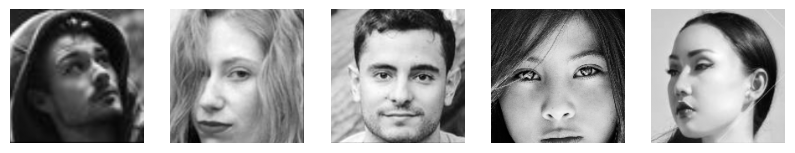

In [12]:
# Visualize a few processed faces
plt.figure(figsize=(10, 2))
for i in range(min(5, len(faces))):
    plt.subplot(1, 5, i+1)
    plt.imshow(faces[i], cmap='gray')
    plt.axis('off')
plt.show()